# Retail Price Recommendation model with Gradient Boosting Tree

### Background
Mercari (Japan’s biggest shopping app) would like to offer pricing suggestions to sellers, but this is not easy because their sellers are enabled to put just about anything, or any bundle of things, on Mercari’s marketplace.
In this machine learning project, we will build a model that automatically suggests the right product prices. 

## 1. Load Data 
The dataset is from Kaggle [Link](https://www.kaggle.com/saitosean/mercari?select=train.tsv)

In [2]:
import gc
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score

import sweetviz as sv

In [3]:
path = 'C:\\Users\\bokhy\\Desktop\\Python\\github\\Python-Projects'  

df = pd.read_csv(os.path.join(path, 'train.tsv'), sep = '\t')
# test = pd.read_csv(os.path.join(path, 'test.tsv'), sep = '\t')

In [97]:
#train, test = train_test_split(train, test_size=0.2) 

In [4]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [5]:
train.shape, test.shape

((1185737, 8), (296798, 8))

In [6]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."


In [7]:
test.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
12,12,Black Skater dress,2,"Women/Dresses/Above Knee, Mini",rue,16.0,0,"Xl, great condition"
23,23,Triple car charger,1,Electronics/Cell Phones & Accessories/Chargers...,NaN,8.0,1,Brand new never used All colors are available ...
41,41,tropical flower print bra from pink,3,Women/Underwear/Bras,PINK,13.0,1,Used buh looks brand new and is washed and rea...


1. train_id — the id of the listing
2. name — the title of the listing
3. item_condition_id — the condition of the items provided by the sellers
4. category_name — category of the listing 
5. brand_name — the name of the brand
6. price — the price that the item was sold for. **Target Variable**
7. shipping — 1 if shipping fee is paid by seller and 0 if it's paid by buyer
8. item_description — the full description of the item

In [12]:
my_report = sv.analyze(train,
                      target_feat = 'price',
                      pairwise_analysis= "on")
my_report.show_html()

:FEATURES DONE:                    |█████████████████████| [100%]   00:23  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:05  -> (00:00 left)
c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  


Creating Associations graph... DONE!


In [13]:
# Compare Train and Test set
my_report = sv.compare([train, "Train Data"], [test, "Test Data"], 
                       target_feat = "price",
                       pairwise_analysis= "on")
my_report.show_html()

:FEATURES DONE:                    |█████████████████████| [100%]   00:34  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:06  -> (00:00 left)
c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  


Creating Associations graph... 

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  


DONE!


## 2.EDA

In [14]:
# Examine Target Variable

Text(0.5, 1.0, 'Price Distribution')

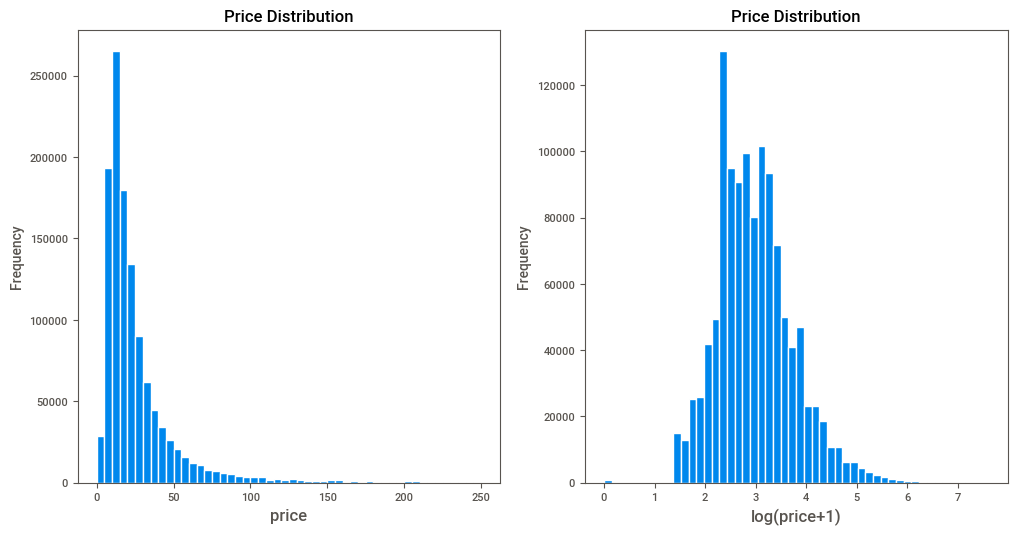

In [15]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [16]:
# 'shipping variable'

In [17]:
train['shipping'].value_counts() / len(train)

0    0.552642
1    0.447358
Name: shipping, dtype: float64

In [18]:
test['shipping'].value_counts() / len(test)

0    0.55306
1    0.44694
Name: shipping, dtype: float64

In both train and test set, 55% of items has a value of '0', which means that shipping fee were paid by the buyers. \
How shipping related to price?

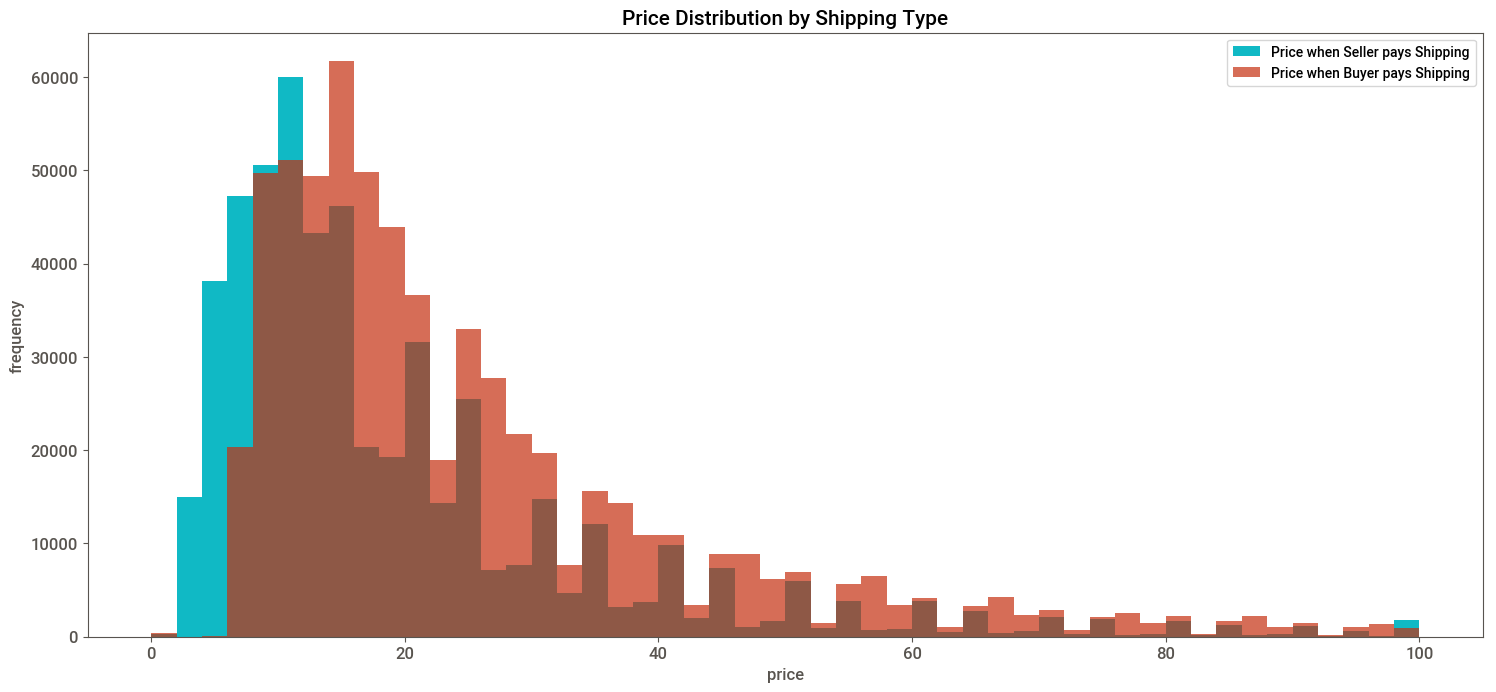

In [19]:
shipping_fee_by_buyer = train.loc[train['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[train['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#10B9C5', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#C52F10', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [20]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.6 if seller pays shipping
The average price is 30.13 if buyer pays shipping


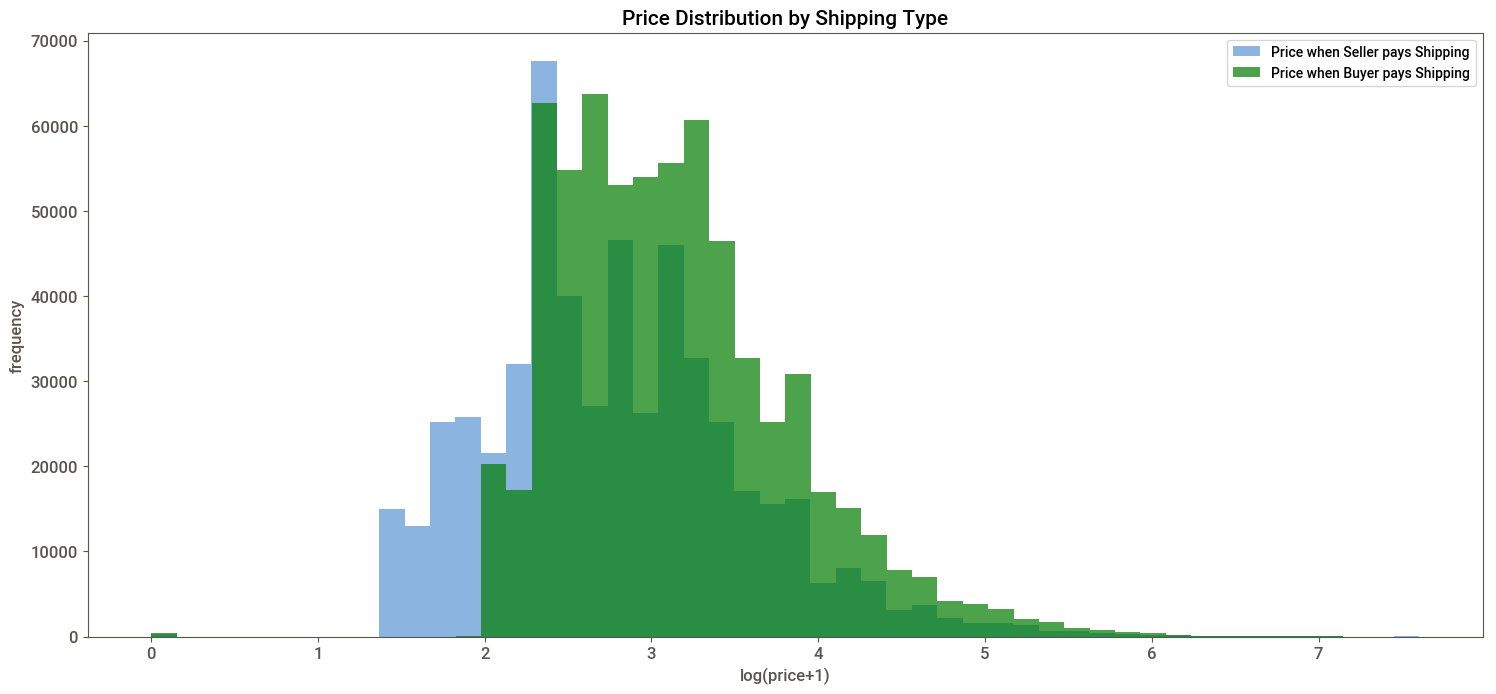

In [21]:
# Log transformed version
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

We can see that the average price is **higher** when buyer pays shipping.

##### Category Names

In [22]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 1268 unique values in category name column


In [23]:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 48093
Women/Tops & Blouses/T-Shirts                                  37133
Beauty/Makeup/Face                                             27548
Beauty/Makeup/Lips                                             23908
Electronics/Video Games & Consoles/Games                       21249
Beauty/Makeup/Eyes                                             20241
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    19709
Women/Underwear/Bras                                           16945
Women/Tops & Blouses/Blouse                                    16288
Women/Tops & Blouses/Tank, Cami                                16188
Name: category_name, dtype: int64

##### Item condition vs. Price

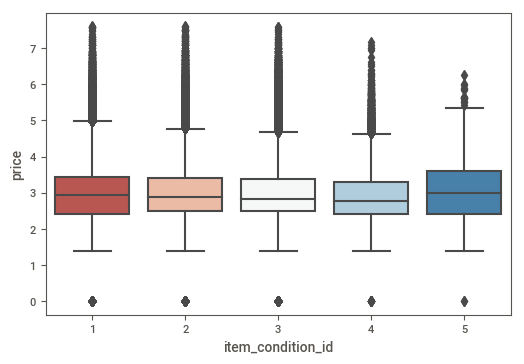

In [24]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

Therefore, we are going to use all the features to build our model.

## 3. Create a Model

### (1) Hyperparameter setting

In [25]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [26]:
print('There are %d items where category name is missing .' %train['category_name'].isnull().sum())

There are 5069 items where category name is missing .


In [27]:
print('There are %d items where brand name is missing.' %train['brand_name'].isnull().sum())

There are 506181 items where brand name is missing.


In [28]:
print('There are %d items where description is missing.' %train['item_description'].isnull().sum())

There are 4 items where description is missing.


### (2) Data Pre-processing
###### Helper functions

In [29]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)

In [30]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [31]:
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [32]:
# drop target column
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])

In [33]:
# Delete rows where price = 0
train = train[train.price != 0].reset_index(drop=True)

nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [34]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [35]:
# merge = merge.drop('test_id', axis=1)
merge.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
1,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
2,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
3,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity
4,5,Bundled items requested for Ruie,3,Women/Other/Other,missing,59.0,0,"Banana republic bottoms, Candies skirt with ma..."


In [36]:
merge.shape

(1481835, 8)

#### Count vectorize name and category name columns.

In [37]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

In [38]:
X_name

<1481835x17732 sparse matrix of type '<class 'numpy.int64'>'
	with 6066993 stored elements in Compressed Sparse Row format>

In [39]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [40]:
X_category

<1481835x1012 sparse matrix of type '<class 'numpy.int64'>'
	with 5933344 stored elements in Compressed Sparse Row format>

#### TFIDF Vectorize item_description column.

In [41]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [42]:
X_description

<1481835x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 33047118 stored elements in Compressed Sparse Row format>

#### Label binarize brand_name column.

In [43]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [44]:
X_brand

<1481835x4001 sparse matrix of type '<class 'numpy.int32'>'
	with 1481835 stored elements in Compressed Sparse Row format>

#### Create dummy variables for item_condition_id and shipping columns.

In [45]:
aa = pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True)

In [46]:
aa = np.array(aa, dtype=float)

In [47]:
X_dummies = csr_matrix(aa)

In [48]:
X_dummies

<1481835x6 sparse matrix of type '<class 'numpy.float64'>'
	with 2144677 stored elements in Compressed Sparse Row format>

#### Create sparse merge

In [49]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [50]:
sparse_merge.shape

(1481835, 72751)

#### Remove features with document frequency <=1.

In [51]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [52]:
sparse_merge.shape

(1481835, 72285)

#### Separate train and test data from sparse merge.

In [53]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [54]:
train_X = lgb.Dataset(X, label=y)

In [55]:
params = {
        'learning_rate': 0.02,
        'application': 'regression',
        'max_depth': 9,
        'num_leaves': 30,
        'verbosity': -1,
        'metric': 'RMSE',
    }

In [56]:
# Start Training
gbm = lgb.train(params, train_X, num_boost_round=1000, verbose_eval=100)

## 4. Inference using Test set

In [57]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [58]:
y_pred

array([2.39003494, 3.75873855, 2.85574048, ..., 2.63401498, 2.7621529 ,
       2.49262279])

In [59]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.5309652205674069


## 5. Improvements

1. Fine-tuning hyperparameters
2. Pre-processing

Reference
>https://www.kaggle.com/tunguz/more-effective-ridge-lgbm-script-lb-0-44823
>https://towardsdatascience.com/machine-learning-for-retail-price-suggestion-with-python-64531e64186d